In [ ]:
!chmod 600 ~/.passwd-s3fs

In [ ]:
!apt install s3fs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
s3fs is already the newest version (1.82-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!mkdir /content/s3

mkdir: cannot create directory ‘/content/s3’: File exists
s3fs: MOUNTPOINT directory /content/s3 is not empty. if you are sure this is safe, can use the 'nonempty' mount option.


In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics

CheXpert Gender Model Validation on MIMIC Test Set

In [ ]:
df = pd.read_csv('/content/mimic_gender_split.csv')
df['path'] = 's3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
chexpert_gender_model = load_learner('/content/chexpert_gender.pkl')

In [ ]:
chexpert_gender_model.dls.to(device='cuda')
chexpert_gender_model.model.to(device='cuda')
gender_test_dl = chexpert_gender_model.dls.test_dl(test_df)
gender_preds = chexpert_gender_model.get_preds(dl=gender_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Gender'] = test_df[['Gender']]
predict_df['Gender_Tensor_Id'] =gender_preds[2].numpy()
predict_df['Gender_Probability'] =gender_preds[0].numpy().tolist()

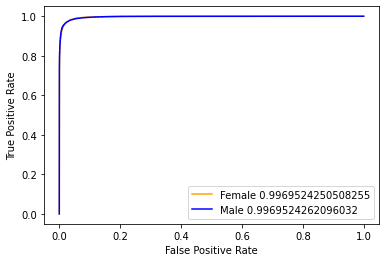

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[0] for prob in predict_df['Gender_Probability']], pos_label = 'F')
plt.plot(fpr,tpr, color='orange', label='Female ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[1] for prob in predict_df['Gender_Probability']], pos_label = 'M')
plt.plot(fpr,tpr, color='blue', label='Male ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Gender_Tensor_Id', gender_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Gender_Probability', gender_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/chexpert_gender_mimic_test.csv')

         index                                      dicom_id  subject_id  \
4            4  d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738    10000935   
5            6  9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b    10000935   
6            8  8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30    10000935   
7           10  88498b37-c21dc7ba-bc202800-b517a62d-f7ac5bcf    10000935   
113        416  cdd1bd42-770fcd05-16836b10-98a10e4a-f7b45ac2    10005024   
...        ...                                           ...         ...   
210254  630320  d866433d-4f597944-7222fc85-ab777777-1717dc69    19997473   
210257  630323  826b4469-6017264c-2ddd12e8-2e3e5c4c-fe2817bd    19997911   
210258  630328  b7fea537-87829311-389dc1c3-0947f202-bcf5f743    19998330   
210268  630343  3fcd0406-9b111603-feae7033-96632b3a-111333e5    19999733   
210269  630344  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
4       505789

NIH Gender Model Validation on MIMIC Test Set

In [ ]:
df = pd.read_csv('/content/mimic_gender_split.csv')
df['path'] = 's3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
nih_gender_model = load_learner('/content/nih_gender.pkl')

In [ ]:
nih_gender_model.dls.to(device='cuda:2')
nih_gender_model.model.to(device='cuda:2')
gender_test_dl = nih_gender_model.dls.test_dl(test_df, num_workers = 10)
gender_preds = nih_gender_model.get_preds(dl=gender_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Gender'] = test_df[['Gender']]
predict_df['Gender_Tensor_Id'] =gender_preds[2].numpy()
predict_df['Gender_Probability'] =gender_preds[0].numpy().tolist()

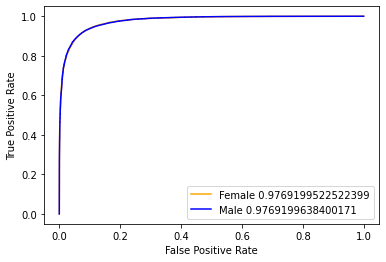

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[0] for prob in predict_df['Gender_Probability']], pos_label = 'F')
plt.plot(fpr,tpr, color='orange', label='Female ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[1] for prob in predict_df['Gender_Probability']], pos_label = 'M')
plt.plot(fpr,tpr, color='blue', label='Male ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Gender_Tensor_Id', gender_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Gender_Probability', gender_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/nih_gender_mimic_test.csv')

         index                                      dicom_id  subject_id  \
4            4  d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738    10000935   
5            6  9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b    10000935   
6            8  8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30    10000935   
7           10  88498b37-c21dc7ba-bc202800-b517a62d-f7ac5bcf    10000935   
113        416  cdd1bd42-770fcd05-16836b10-98a10e4a-f7b45ac2    10005024   
...        ...                                           ...         ...   
210254  630320  d866433d-4f597944-7222fc85-ab777777-1717dc69    19997473   
210257  630323  826b4469-6017264c-2ddd12e8-2e3e5c4c-fe2817bd    19997911   
210258  630328  b7fea537-87829311-389dc1c3-0947f202-bcf5f743    19998330   
210268  630343  3fcd0406-9b111603-feae7033-96632b3a-111333e5    19999733   
210269  630344  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
4       505789

MIMIC Gender Model Validation on MIMIC Test Set

In [ ]:
df = pd.read_csv('/content/mimic_gender_split.csv')
df['path'] = '/content/s3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
mimic_gender_model = load_learner('/content/mimic_gender.pkl')

In [ ]:
mimic_gender_model.dls.to(device='cuda:2')
mimic_gender_model.model.to(device='cuda:2')
gender_test_dl = mimic_gender_model.dls.test_dl(test_df, num_workers = 10)
gender_preds = mimic_gender_model.get_preds(dl=gender_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Gender'] = test_df[['Gender']]
predict_df['Gender_Tensor_Id'] =gender_preds[2].numpy()
predict_df['Gender_Probability'] =gender_preds[0].numpy().tolist()

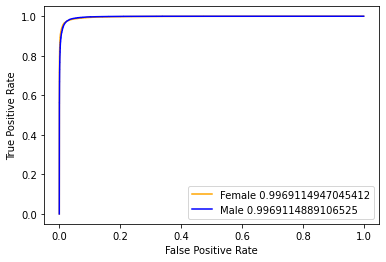

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[0] for prob in predict_df['Gender_Probability']], pos_label = 'F')
plt.plot(fpr,tpr, color='orange', label='Female ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[1] for prob in predict_df['Gender_Probability']], pos_label = 'M')
plt.plot(fpr,tpr, color='blue', label='Male ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Gender_Tensor_Id', gender_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Gender_Probability', gender_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/mimic_gender_mimic_test.csv')

         index                                      dicom_id  subject_id  \
4            4  d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738    10000935   
5            6  9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b    10000935   
6            8  8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30    10000935   
7           10  88498b37-c21dc7ba-bc202800-b517a62d-f7ac5bcf    10000935   
113        416  cdd1bd42-770fcd05-16836b10-98a10e4a-f7b45ac2    10005024   
...        ...                                           ...         ...   
210254  630320  d866433d-4f597944-7222fc85-ab777777-1717dc69    19997473   
210257  630323  826b4469-6017264c-2ddd12e8-2e3e5c4c-fe2817bd    19997911   
210258  630328  b7fea537-87829311-389dc1c3-0947f202-bcf5f743    19998330   
210268  630343  3fcd0406-9b111603-feae7033-96632b3a-111333e5    19999733   
210269  630344  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
4       505789